## Testing Scoring Model (feature importance/r2/mae values)

In this notebook I am attempting to test out the hotspot model and different combinations of features. I have physically written out the results and will upload images of the results outside of this notebook to get the best results to make our model output a more accurate score.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import asksaveasfilename

In [6]:
# Load clean file with all features enginnered for jan-feb
Tk().withdraw()
file_path = askopenfilename(title="Select Jan–Feb Cleaned with Features CSV")
df = pd.read_csv(file_path)

print("Loaded:", file_path)
print(df.shape)

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
(5609910, 30)


## Load hotspot model 

In [9]:
# Load the cleaned Jan–Feb dataset
Tk().withdraw()
trip_file = askopenfilename(title="Select Cleaned Jan–Feb Trip Data CSV")
df = pd.read_csv(trip_file)
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

#  Filter to only February (since hotspot predictions only cover February)
df_feb = df[df['pickup_date'].dt.month == 2].copy()

#  Load the updated hotspot predictions
hotspot_file = askopenfilename(title="Select Updated Hotspot Predictions CSV")
hotspot_df = pd.read_csv(hotspot_file)

# Prepare both for merge
hotspot_df.rename(columns={'predicted_trip_count': 'hotspot_score'}, inplace=True)
hotspot_df['pickup_date'] = pd.to_datetime(hotspot_df['pickup_date'])
hotspot_df['pickup_hour'] = hotspot_df['pickup_hour'].astype(int)
hotspot_df['pickup_zone'] = hotspot_df['pickup_zone'].astype(str)

df_feb['pickup_hour'] = df_feb['pickup_hour'].astype(int)
df_feb['pickup_zone'] = df_feb['pickup_zone'].astype(str)

#  Merge hotspot score into February data
df_feb = df_feb.merge(
    hotspot_df[['pickup_zone', 'pickup_hour', 'pickup_date', 'hotspot_score']],
    on=['pickup_zone', 'pickup_hour', 'pickup_date'],
    how='left'
)

# Confirm the merge worked
missing_rate = df_feb['hotspot_score'].isnull().mean()
print(f" Missing hotspot_score values (Feb only): {missing_rate:.2%}")

# Save updated February dataset
save_path = asksaveasfilename(
    title="Save Updated Feb-Only Dataset with Hotspot Score",
    defaultextension=".csv",
    filetypes=[("CSV Files", "*.csv")],
    initialfile="Cleaned_Feb_with_Hotspot.csv"
)
if save_path:
    df_feb.to_csv(save_path, index=False)
    print(f" File saved to: {save_path}")
else:
    print(" Save canceled.")


 Missing hotspot_score values (Feb only): 0.00%
 File saved to: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/Cleaned_Feb_with_Hotspot.csv


In [4]:
# Create merge key in both DataFrames
df['merge_key'] = df['pickup_zone'] + '_' + df['pickup_hour'].astype(str) + '_' + df['pickup_date'].astype(str)
hotspot_df['merge_key'] = hotspot_df['pickup_zone'] + '_' + hotspot_df['pickup_hour'].astype(str) + '_' + hotspot_df['pickup_date'].astype(str)

# Check how many merge keys match
shared_keys = set(df['merge_key']).intersection(set(hotspot_df['merge_key']))
print(f"Total keys in df: {df['merge_key'].nunique()}")
print(f"Total keys in hotspot_df: {hotspot_df['merge_key'].nunique()}")
print(f"Shared keys: {len(shared_keys)}")


Total keys in df: 121747
Total keys in hotspot_df: 59141
Shared keys: 58496


## XGBoost with Boroughs added back in

In this we will add boroughs back in and test and see if it works well with sin/cos hours as well as the additional data cleaning and log fare_per_minute, will also test to see if hotspot score comes back it may not here since it didnt the og time, but it may in lightgbm

In [11]:
# comparing with log fare_per_minute

# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Also log-transform fare_per_mile if not already done
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Final features (after removing boroughs and time_of_day)
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score',  
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Preprocess datetime and filter rows
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])  # Drop rows with missing original target

# Encode sin/cos hour
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Time-based split (Jan → train, Feb → test)
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# Preprocess categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']  # log-transformed for training
y_test = test_df['fare_per_minute']        # original scale for evaluation

# Train model
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output results
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/jan_feb_all_features.csv
Shape: (5609910, 32)

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.4335
MAE: 0.1715

Top Features:
dropoff_borough_EWR          0.309659
fare_per_mile                0.222582
is_airport_trip              0.091446
trip_duration_variability    0.085614
dropoff_borough_Brooklyn     0.059010
cos_hour                     0.050330
pickup_borough_Queens        0.038808
dropoff_borough_Queens       0.037615
sin_hour                     0.027236
pickup_borough_Brooklyn      0.025678
dtype: float32


## Lightgbm wiht boroughs added back

Here we will do the same test above but along side model improvance see if hotspot_score comes back

In [3]:


# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Log-transform fare_per_mile for modeling
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score',
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Date/time handling
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Add sin/cos hour encodings
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encoding for categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final input matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # Original scale for evaluation

# Train LightGBM model
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log transform
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/jan_feb_all_features.csv
Shape: (5609910, 32)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 2871008, number of used features: 15
[LightGBM] [Info] Start training from score 0.806685

Time-Based Evaluation LightGBM (Train: Jan, Test: Feb):
R² Score: 0.4167
MAE: 0.1742

Top Features:
fare_per_mile                1211
trip_duration_variability     506
dropoff_zone_hotness          370
cos_hour                      241
sin_hour                      226
is_airport_trip               104
pickup_borough_Queens          74
dropoff_borough_EWR            61
dropoff_borough_Manhattan   

In [6]:
df[['hotspot_score', 'dropoff_zone_hotness', 'trip_duration_variability']].corr()


,hotspot_score,dropoff_zone_hotness,trip_duration_variability
hotspot_score,1.000000,0.259990,0.175517
dropoff_zone_hotness,0.259990,1.000000,0.121064
trip_duration_variability,0.175517,0.121064,1.000000


1) low to moderate correlation - not redundant 

2) weak correlation - adds separate info 

3) very weak - no concern 

There are no multicollinerality issues ie hotspot score is not strongly correlated with other features and should be useful for the model

In [8]:
df['hotspot_score'].describe()


count    2.738902e+06
mean     1.582146e+02
std      1.054923e+02
min      6.192988e-01
25%      7.987817e+01
50%      1.429955e+02
75%      2.115958e+02
max      5.531128e+02
Name: hotspot_score, dtype: float64

this is the hotspot score summary it confirms it is not static or constant it has a healthy range and variance and exclusion is not due to top feature improtance is not due to static or dead columns

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/jan_feb_all_features.csv
Shape: (5609910, 32)


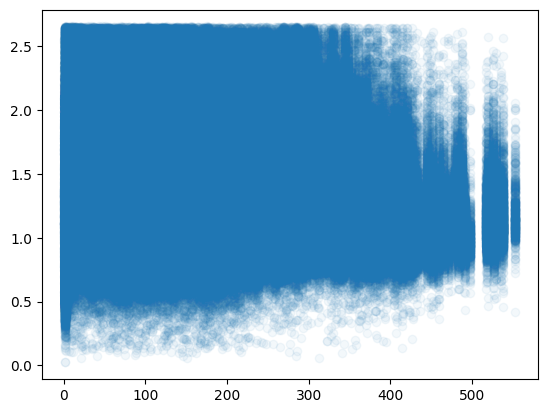

In [ ]:

# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)


df[['hotspot_score', 'fare_per_minute']].corr()

plt.scatter(df['hotspot_score'], df['fare_per_minute'], alpha=0.05)



## Xgboost with borough and sin/cos but not hotspot score

In [4]:
# comparing with log fare_per_minute

# Load the cleaned  file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Also log-transform fare_per_mile if not already done
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Final features (after removing boroughs and time_of_day)
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score',  
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Preprocess datetime and filter rows
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])  # Drop rows with missing original target

# Encode sin/cos hour
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Time-based split (Jan → train, Feb → test)
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# Preprocess categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']  # log-transformed for training
y_test = test_df['fare_per_minute']        # original scale for evaluation

# Train model
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output results
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
Shape: (5609910, 30)

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.4335
MAE: 0.1715

Top Features:
dropoff_borough_EWR          0.309659
fare_per_mile                0.222582
is_airport_trip              0.091446
trip_duration_variability    0.085614
dropoff_borough_Brooklyn     0.059010
cos_hour                     0.050330
pickup_borough_Queens        0.038808
dropoff_borough_Queens       0.037615
sin_hour                     0.027236
pickup_borough_Brooklyn      0.025678
dtype: float32


## Lightgbm with borough and sin/cos but not hotspot score

In [5]:

# Load the cleaned file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned  with Features")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Log-transform fare_per_mile for modeling
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score',
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Date/time handling
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Add sin/cos hour encodings
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encoding for categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final input matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)

print("Final features used in model:")
print(X_train.columns.tolist())

X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # Original scale for evaluation

# Train LightGBM model
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log transform
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
Shape: (5609910, 30)
Final features used in model:
['fare_per_mile', 'dropoff_zone_hotness', 'trip_duration_variability', 'sin_hour', 'cos_hour', 'is_airport_trip', 'pickup_borough_Brooklyn', 'pickup_borough_EWR', 'pickup_borough_Manhattan', 'pickup_borough_Queens', 'pickup_borough_Staten Island', 'dropoff_borough_Brooklyn', 'dropoff_borough_EWR', 'dropoff_borough_Manhattan', 'dropoff_borough_Queens', 'dropoff_borough_Staten Island']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 2871008, number of used features: 1

## Xgboost with Borough and time of day and hotspot

This is just like the first ones instead of this time we are seeing how these features play out with the new introduced log fare_minute and capped features

In [8]:
# Load file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned CSV with Hotspot Score")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough', 'time_of_day']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score'
]
feature_cols = categorical_cols + numeric_cols

# Ensure datetime is parsed
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Drop sin/cos hour features if present
df.drop(columns=['sin_hour', 'cos_hour', 'pickup_hour'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encode categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrix
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # original scale for evaluation

# Train LightGBM
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale


# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))


Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/jan_feb_all_features.csv
Shape: (5609910, 32)

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.4279
MAE: 0.1725

Top Features:
dropoff_borough_EWR          0.248934
fare_per_mile                0.201140
is_airport_trip              0.106855
trip_duration_variability    0.079791
dropoff_borough_Brooklyn     0.071249
time_of_day_Evening Rush     0.063073
time_of_day_Night            0.048144
time_of_day_Midday           0.036531
dropoff_borough_Queens       0.029728
dropoff_borough_Manhattan    0.028556
dtype: float32


## Lightgbm with borough and time of day and hotspot

In [9]:
# Load file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned CSV with Hotspot Score")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough', 'time_of_day']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score'
]
feature_cols = categorical_cols + numeric_cols

# Ensure datetime is parsed
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Drop sin/cos hour features if present
df.drop(columns=['sin_hour', 'cos_hour', 'pickup_hour'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encode categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrix
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # original scale for evaluation

# Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/jan_feb_all_features.csv
Shape: (5609910, 32)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 2871008, number of used features: 17
[LightGBM] [Info] Start training from score 0.806685

Time-Based Evaluation LightGBM (Train: Jan, Test: Feb):
R² Score: 0.4112
MAE: 0.1751

Top Features:
fare_per_mile                1219
trip_duration_variability     555
dropoff_zone_hotness          402
time_of_day_Evening Rush      112
is_airport_trip               108
time_of_day_Night              85
time_of_day_Midday             83
time_of_day_Morning Rush       74
pickup_borough_Queens       

## Xgboost with borough and time of day without hotspot

In [10]:
# Load file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned CSV ")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough', 'time_of_day']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score'
]
feature_cols = categorical_cols + numeric_cols

# Ensure datetime is parsed
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Drop sin/cos hour features if present
df.drop(columns=['sin_hour', 'cos_hour', 'pickup_hour'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encode categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrix
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # original scale for evaluation

# Train LightGBM
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale


# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))


Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
Shape: (5609910, 30)

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.4279
MAE: 0.1725

Top Features:
dropoff_borough_EWR          0.248934
fare_per_mile                0.201140
is_airport_trip              0.106855
trip_duration_variability    0.079791
dropoff_borough_Brooklyn     0.071249
time_of_day_Evening Rush     0.063073
time_of_day_Night            0.048144
time_of_day_Midday           0.036531
dropoff_borough_Queens       0.029728
dropoff_borough_Manhattan    0.028556
dtype: float32


## lightgbm with borough and time of day without hotspot

In [11]:
# Load file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned CSV ")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough', 'time_of_day']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score'
]
feature_cols = categorical_cols + numeric_cols

# Ensure datetime is parsed
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Drop sin/cos hour features if present
df.drop(columns=['sin_hour', 'cos_hour', 'pickup_hour'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encode categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrix
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # original scale for evaluation

# Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
Shape: (5609910, 30)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 2871008, number of used features: 17
[LightGBM] [Info] Start training from score 0.806685

Time-Based Evaluation LightGBM (Train: Jan, Test: Feb):
R² Score: 0.4112
MAE: 0.1751

Top Features:
fare_per_mile                1219
trip_duration_variability     555
dropoff_zone_hotness          402
time_of_day_Evening Rush      112
is_airport_trip               108
time_of_day_Night              85
time_of_day_Midday             83
time_of_day_Morning Rus

## Merging Correctly

In [24]:


# Step 1: Load full Jan–Feb dataset (with engineered features)
Tk().withdraw()
trip_file = askopenfilename(title="Select Jan–Feb Trip Dataset (Original)")
df = pd.read_csv(trip_file)
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Step 2: Load February hotspot predictions
hotspot_file = askopenfilename(title="Select February Hotspot Predictions CSV")
hotspot_df = pd.read_csv(hotspot_file)

# Step 3: Prepare hotspot prediction file
hotspot_df.rename(columns={'predicted_trip_count': 'hotspot_score'}, inplace=True)
hotspot_df['pickup_date'] = pd.to_datetime(hotspot_df['pickup_date'])
hotspot_df['pickup_hour'] = hotspot_df['pickup_hour'].astype(int)
hotspot_df['pickup_zone'] = hotspot_df['pickup_zone'].astype(str)

# Step 4: Extract February rows from trip data
df_feb = df[df['pickup_date'].dt.month == 2].copy()
df_feb['pickup_hour'] = df_feb['pickup_hour'].astype(int)
df_feb['pickup_zone'] = df_feb['pickup_zone'].astype(str)

# Step 5: Merge hotspot predictions into Feb rows
df_feb = df_feb.merge(
    hotspot_df[['pickup_zone', 'pickup_hour', 'pickup_date', 'hotspot_score']],
    on=['pickup_zone', 'pickup_hour', 'pickup_date'],
    how='left'
)

# Step 6: Fill missing hotspot_score with 0 (unseen zone/hour/date)
df_feb['hotspot_score'] = df_feb['hotspot_score'].fillna(0)

# Step 7: Reattach January rows (no hotspot_score)
df_jan = df[df['pickup_date'].dt.month == 1].copy()
df_jan['hotspot_score'] = 0

# Step 8: Combine full dataset
df_combined = pd.concat([df_jan, df_feb], ignore_index=True)

# Confirm structure
print("\n Combined Shape:", df_combined.shape)
print("Missing hotspot_score:", df_combined['hotspot_score'].isnull().mean())
print("All columns in combined dataset:", df_combined.columns.tolist())

# Step 9: Save to file
save_path = asksaveasfilename(
    title="Save Combined Jan–Feb with Hotspot Score",
    defaultextension=".csv",
    filetypes=[("CSV Files", "*.csv")],
    initialfile="Jan_Feb_With_Hotspot.csv"
)

if save_path:
    df_combined.to_csv(save_path, index=False)
    print(f" File saved to: {save_path}")
else:
    print(" Save canceled.")


print("All columns:", df.columns.tolist())




 Combined Shape: (5609910, 31)
Missing hotspot_score: 0.0
All columns in combined dataset: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'service_zone', 'fare_per_minute', 'fare_per_mile', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend', 'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip', 'dropoff_day_of_week', 'dropoff_hour', 'dropoff_zone_hotness', 'log_dropoff_zone_hotness', 'trip_duration_variability', 'hotspot_score']
 File saved to: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/Jan_Feb_With_Hotspot_Best.csv
All columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone',

## XGBoost wiht Borughs sin/cos and fixed hotspot 

For now I will only use feb onlt split for quixk testing if it works out I will rewrite the code to do jan+ feb merge and restuor full training/testing

In [25]:
# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Also log-transform fare_per_mile if not already done
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Final features (after removing boroughs and time_of_day)
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score',  
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Preprocess datetime and filter rows
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])  # Drop rows with missing original target

# Encode sin/cos hour
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Time-based split (Jan → train, Feb → test)
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# Preprocess categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']  # log-transformed for training
y_test = test_df['fare_per_minute']        # original scale for evaluation

# Train model
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output results
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/Jan_Feb_With_Hotspot_Best.csv
Shape: (5609910, 31)

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.4335
MAE: 0.1715

Top Features:
dropoff_borough_EWR          0.309659
fare_per_mile                0.222582
is_airport_trip              0.091446
trip_duration_variability    0.085614
dropoff_borough_Brooklyn     0.059010
cos_hour                     0.050330
pickup_borough_Queens        0.038808
dropoff_borough_Queens       0.037615
sin_hour                     0.027236
pickup_borough_Brooklyn      0.025678
dtype: float32


## LightGBm wiht Borughs sin/cos and fixed hotspot 

For now I will only use feb onlt split for quixk testing if it works out I will rewrite the code to do jan+ feb merge and restuor full training/testing

In [27]:

# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features + Hotspot")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)


# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Log-transform fare_per_mile for modeling
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    'hotspot_score',
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Date/time handling
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Add sin/cos hour encodings
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Train/test split
train_df = df[df['pickup_date'].dt.month == 1].copy()
test_df = df[df['pickup_date'].dt.month == 2].copy()

# One-hot encoding for categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final input matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # Original scale for evaluation

# Train LightGBM model
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log transform
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(15))

Loaded: C:/diksha/Summer Sem/DataAnalysis/Data/Full Scoring Model/Jan_Feb_With_Hotspot_Best.csv
Shape: (5609910, 31)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 2871008, number of used features: 15
[LightGBM] [Info] Start training from score 0.806685

Time-Based Evaluation LightGBM (Train: Jan, Test: Feb):
R² Score: 0.4167
MAE: 0.1742

Top Features:
fare_per_mile                   1211
trip_duration_variability        506
dropoff_zone_hotness             370
cos_hour                         241
sin_hour                         226
is_airport_trip                  104
pickup_borough_Queens             74
dropoff_borough_EWR               61